# Exercício 3:
* Montar o ambiente para executar tensorflow com gpu (tensorflow-gpu): OK
* Executar código do mnist: OK, executado no notebook da aula
* Fazer teste com uma rede treinada (VGG16): OK, executado no notebook da aula
* Utilizar a mesma topologia de rede neural usada para o problema minist, aplicando para o problema das abelhas
* Compare o tempo de treino da rede neural CNN usando CPUxGPU

# Conclusões
* os itens 1, 2 e 3 já havia feito durante a aula, funcionando corretamente
* o uso da conv2d estava causando estouro de memória na GPU
    * solução foi alterar a variável de ambiente os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
* usando a mesma topologia da MNIST para as abelhas mostrou desempenho ruim
    * observamos overfitting antes da época 10, e acurácia final de apenas 0.26 na base de teste
    * a base é altamente desbalanceada (as classes sicula e major por exemplo possuem apenas 10 exemplares)
    * o número de amostras é bastante pequeno, uma estratégia de data augmentation poderia suprir classes pouco representadas
    * o problema Abelhas é mais complexo, deveríamos rever a topologia 
    * vamos testar acrescentar dropout nas camadas fully connected
    * vamos testar acrescentar BatchNormalisation nas camadas convolucionais
* a adição de muitas novas camadas, e diversos mecanismos de regularização não resolveu o problema
    * overfitting continua muito presente
    * a adição de novas camadas não adicionou nenhuma melhoria significativa de performance
    * vamos partir para a próxima abordagem, vamos tentar corrigir o tamanho da base de dados usando data augmentation
    * em última análise, a causa do overfitting pode ser devido incapacidade da rede generalizar um dataset muito pequeno
    * o overfitting foi controlado com a base aumentada e várias técnicas de regularização, porém ainda está bastante instável
* removemos a categoria com muito pouco amostras e removemos algumas imagens outliers (sujas)
    * as categorias sicura e major com apenas 10 imagens foram descartadas, assim como algumas imagens que estavam muito manchadas com fitas ou rasgadas    
* o tempo de treinamento para uma mesma rede foi 98% mais rápida usando a GPU, para diferentes valores de batch_size

## Treino Abelhas

In [1]:
# criei uma classe para abstrair a inicialização dos workers, GPU/CPU, dataset e plots

from rubia_cnn import * 
from stridednet import *

## Treino usando a base de imagens original

In [2]:
def extractInfo(name):
    category = name.split(' ')
    return category[0]

def createData(path, width, height, to_cat=False):
    X, y = [], []
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = extractInfo(category)
        img_array = cv2.imread(os.path.join(path, p), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(height, width))
        X.append(new_img_array)
        y.append(category)
    X = np.array(X)
    X = X.reshape((X.shape[0], height, width, 1))
    X = X.astype('float32') / 255
    y = np.array(y)
    if to_cat:
        le = LabelEncoder()
        yy = le.fit_transform(y)
        y = to_categorical(yy)
        decoder = lambda cat_code: le.inverse_transform(cat_code)
        return X, y, decoder, le.classes_
    return X, y, None, None


path = '/home/lazarop/Downloads/wingsEval'
width, height, depth = 80, 80, 1
X, y, decoder, classes = createData(path, width, height, to_cat=True)

# teste se o decoder está funcionando corretamente
print('Teste do decoder:', decoder([5, 6, 7]))
      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, shuffle=True)

Teste do decoder: ['caucasica' 'cecropia' 'cypria']


### Topologia MNIST


Versions:
Keras : 2.2.4-tf
Tensorflow : 2.1.0

GPU enabled!
Number of workers adjusted to fit the GPUs available
Using 1 GPU workers
CPU test for EYE(10000):  0.26414918899536133
GPU test for EYE(10000):  0.016208648681640625
Multiprocessing status: False

Neural network setup:
X data shape:             (1292, 80, 80, 1)
y data shape:             (1292, 23)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 39, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 39, 39, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 39, 39, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 39, 39, 16)        0         
_________________________

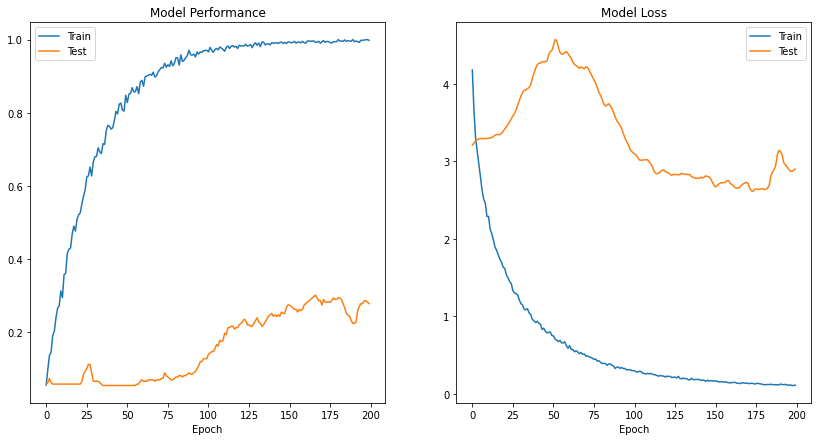


Model evaluation


/home/lazarop/miniconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


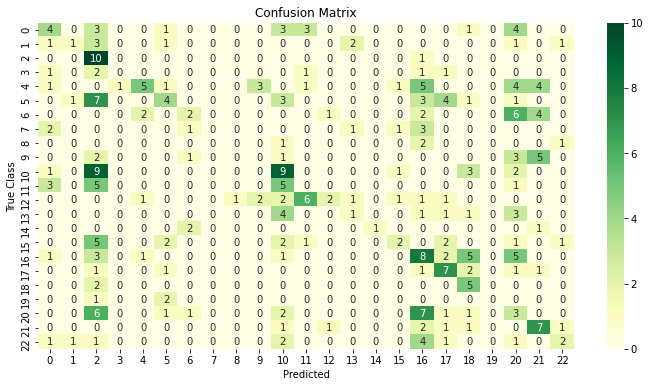

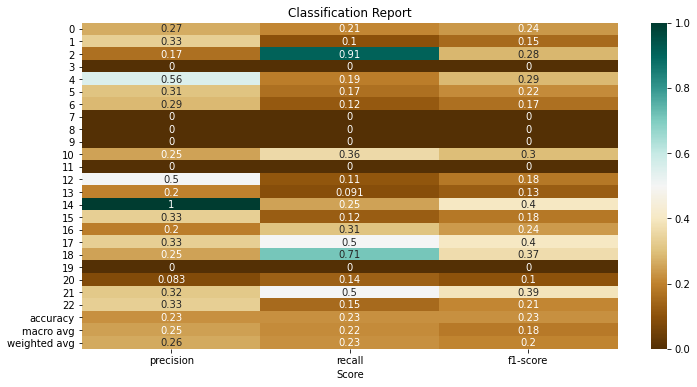

ACCURACY:  22.5 %


In [4]:
gpu = True
workers = 10
epochs = 200
batch_size = 256

k = cnn_keras(X=X_train, y=y_train, gpu=gpu, workers=workers)

opt = Adam(lr=1e-4, decay=1e-4/epochs)
reg = l2(0.0005)

model = StridedNetOne.build(width=width, height=height, depth=depth, 
                            classes=len(classes), reg=reg)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

print('\nTraining started: using ClassOne')
history = model.fit(k.X, k.y, epochs=epochs, batch_size=batch_size, verbose=0, 
                    validation_split=0.2, workers=k.workers, use_multiprocessing=k.multicore)
k.printHistory(history.history, metric='accuracy')

print('\nModel evaluation')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
k.printPerformanceC(X_test, y_test, model=model)

## Otimização da topologia para combater o overfitting e aumentar acurácia


Versions:
Keras : 2.2.4-tf
Tensorflow : 2.1.0

GPU enabled!
Number of workers adjusted to fit the GPUs available
Using 1 GPU workers
CPU test for EYE(10000):  0.26996445655822754
GPU test for EYE(10000):  0.0005495548248291016
Multiprocessing status: False

Neural network setup:
X data shape:             (1292, 80, 80, 1)
y data shape:             (1292, 23)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 78, 78, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 78, 78, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 78, 16)        272       
________________________

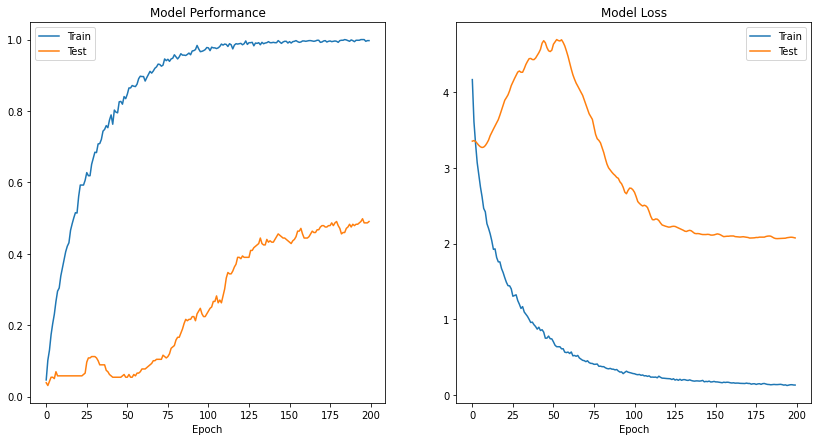


Model evaluation


/home/lazarop/miniconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


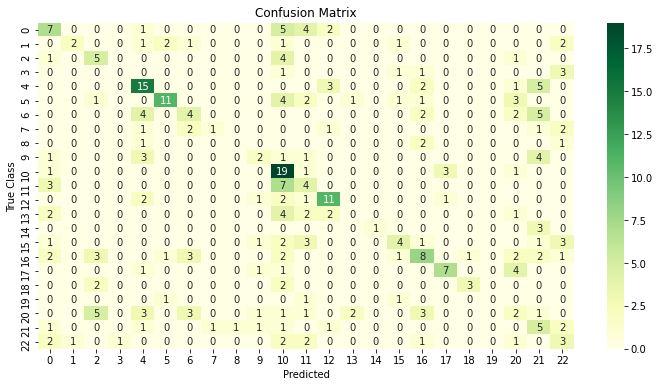

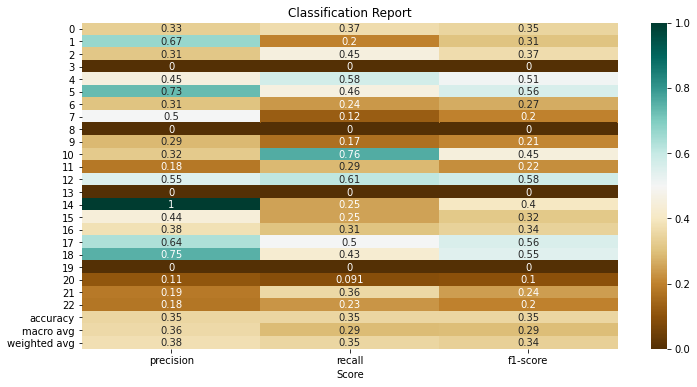

ACCURACY:  35.2 %


In [5]:
gpu = True
workers = 10
epochs = 200
batch_size = 256

k = cnn_keras(X=X_train, y=y_train, gpu=gpu, workers=workers)

opt = Adam(lr=1e-4, decay=1e-4/epochs)
reg = l2(0.0005)

model = StridedNetTwo.build(width=width, height=height, depth=depth, 
                            classes=len(classes), reg=reg)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

print('\nTraining started: using ClassTwo')
history = model.fit(k.X, k.y, epochs=epochs, batch_size=batch_size, verbose=0, 
                    validation_split=0.2, workers=k.workers, use_multiprocessing=k.multicore)
k.printHistory(history.history, metric='accuracy')

print('\nModel evaluation')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
k.printPerformanceC(X_test, y_test, model=model)


Versions:
Keras : 2.2.4-tf
Tensorflow : 2.1.0

GPU enabled!
Number of workers adjusted to fit the GPUs available
Using 1 GPU workers
CPU test for EYE(10000):  0.28142333030700684
GPU test for EYE(10000):  0.011284589767456055
Multiprocessing status: False

Neural network setup:
X data shape:             (1292, 80, 80, 1)
y data shape:             (1292, 23)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 76, 76, 16)        416       
_________________________________________________________________
activation (Activation)      (None, 76, 76, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 76, 76, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 76, 16)        272       
_________________________

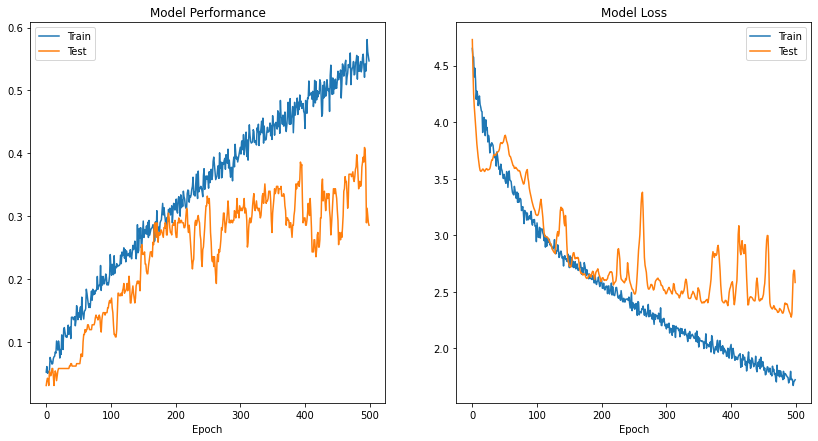


Model evaluation


/home/lazarop/miniconda3/envs/tfgpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


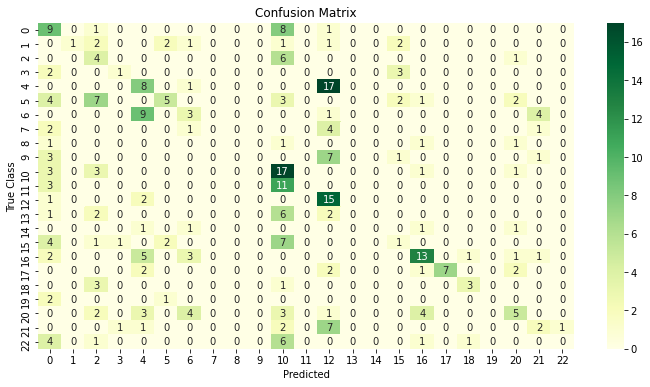

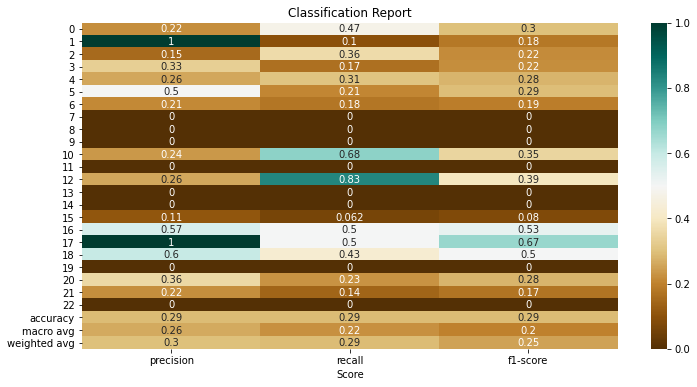

ACCURACY:  29.0 %


In [7]:
gpu = True
workers = 10
epochs = 500
batch_size = 256

k = cnn_keras(X=X_train, y=y_train, gpu=gpu, workers=workers)

opt = Adam(lr=1e-4, decay=1e-4/epochs)
reg = l2(0.0005)

model = StridedNetFour.build(width=width, height=height, depth=depth, 
                            classes=len(classes), reg=reg)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

print('\nTraining started: using ClassFour')
history = model.fit(k.X, k.y, epochs=epochs, batch_size=batch_size, verbose=0, 
                    validation_split=0.2, workers=k.workers, use_multiprocessing=k.multicore)
k.printHistory(history.history, metric='accuracy')

print('\nModel evaluation')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
k.printPerformanceC(X_test, y_test, model=model)

# Data augmentation para aumentar o tamanho da base

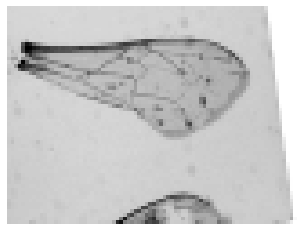

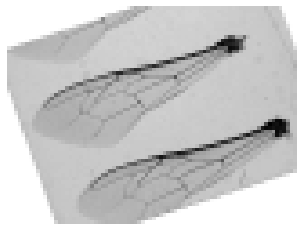

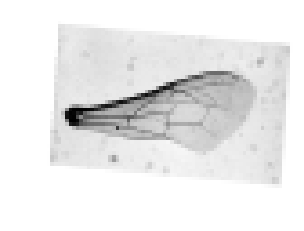

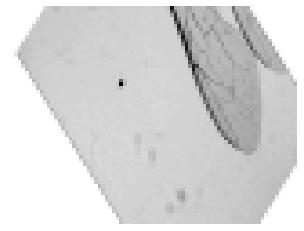

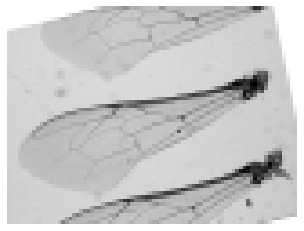

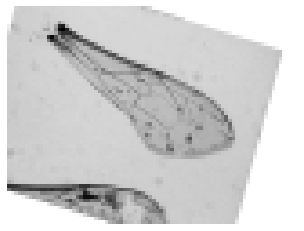

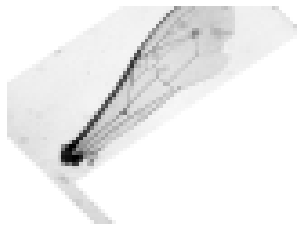

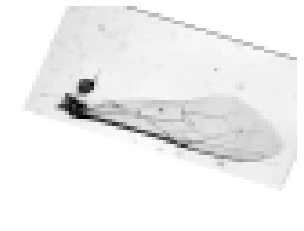

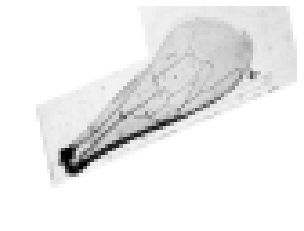

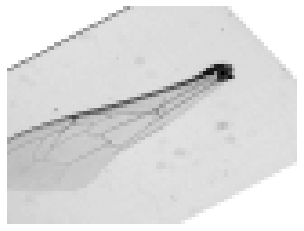

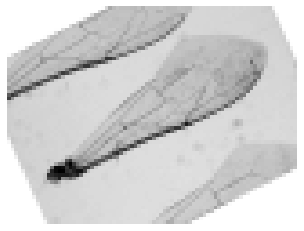

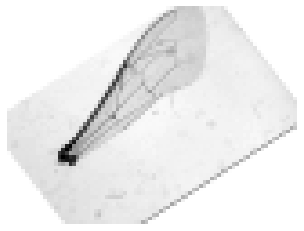

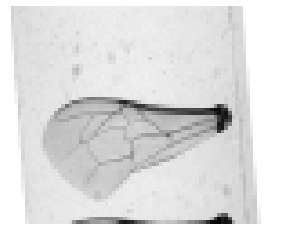

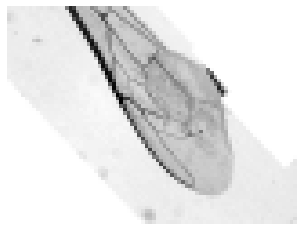

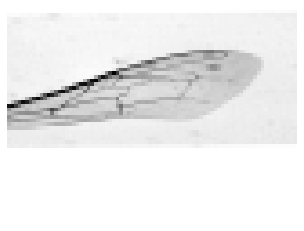

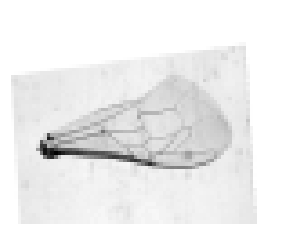

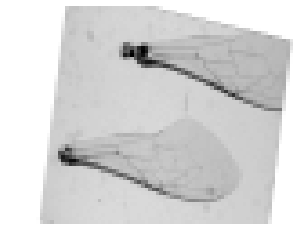

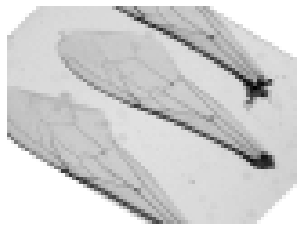

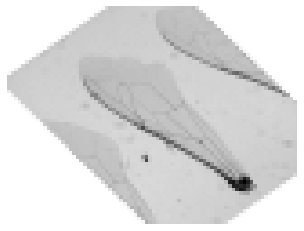

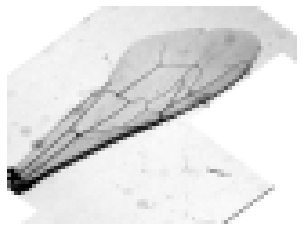

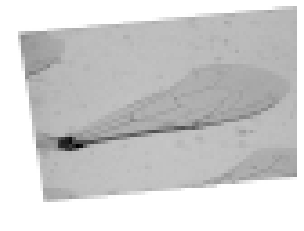

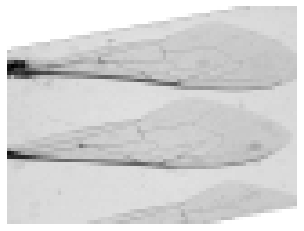

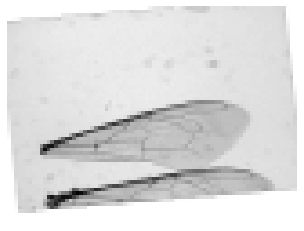

In [6]:
import imutils

path = '/home/lazarop/Downloads/wingsEval/'
path_aug = '/home/lazarop/Downloads/wingsEvalAug/'

variations = 50 # for each input image
dim = 80 # dimensoes da imagem final

           
DATAGEN = ImageDataGenerator(
    rotation_range = 50,
    width_shift_range = 0.10,
    height_shift_range = 0.10,
    #shear_range = 0.05,
    zoom_range = 0.3,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'constant',
    cval = 255)

def generateImgs(path, path_aug, category, imgs, variations, dim):
    for img in imgs:
        image = cv2.imread(path + img, 0)
        x = img_to_array(image)
        x = x.reshape((1,) + x.shape)
        imageGen = DATAGEN.flow(x, batch_size=1, save_to_dir=path_aug, 
                                save_prefix=category, save_format='jpg')
        total = 0
        for new in imageGen:
            total += 1
            if total == variations:
                break
            
def cleanAug(path_aug):
    try:
        os.mkdir(path_aug)
    except:
        for item in os.listdir(path_aug):
            os.remove(path_aug + item)

def preprocessImgs(path_aug, dim):
    ksize = 7
    kernel = np.ones((ksize,ksize), np.uint8)
    for item in os.listdir(path_aug):
        image = cv2.imread(path_aug + item, 0)
        image = imutils.resize(image, width=dim)
        #image = cv2.erode(image, kernel, iterations=1)
        #image = cv2.blur(image, ksize=(ksize, ksize))
        #_, thresh = cv2.threshold(image, 220, 255, cv2.THRESH_BINARY)
        #thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        #thresh = cv2.threshold(image, 80, 90, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        #image = cv2.bitwise_and(image, image, mask=thresh)
        #image[thresh==0] = 255
        #_, image = cv2.threshold(image, 60, 120, cv2.THRESH_BINARY)
        #image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
        #image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        #image = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
        #image = cv2.erode(image, kernel, iterations=1)
        #image = cv2.dilate(image, kernel, iterations=1)
        cv2.imwrite(path_aug + item, image)
        if random.random() < 0.001: # random select a few images to plot: use this to adjust the filters below
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.show()
        
def getImgs(path, path_aug, variations, dim, gen=True):
    if gen:
        cleanAug(path_aug)
        files = []
        for item in os.listdir(path):
            files.append(item)
        df = pd.DataFrame({'file': files})
        df['category'] = df.file.apply(lambda x: x.split('.')[0].split(' ')[0])
        #print(df.groupby('category').count())
        smallest = int(df.groupby('category').count().min())
        for category in df.category.unique():
            raw_samples = df.loc[df.category==category]['file'].sample(smallest).tolist()
            generateImgs(path, path_aug, category, raw_samples, variations, dim)
        preprocessImgs(path_aug, dim)    

        
getImgs(path, path_aug, variations, dim, gen=True)

In [2]:
def extractInfoAug(name):
    category = name.split('_')
    return category[0]

def createDataAug(path, width, height, to_cat=False):
    X, y = [], []
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = extractInfoAug(category)
        img_array = cv2.imread(os.path.join(path, p), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(height, width))
        X.append(new_img_array)
        y.append(category)
    X = np.array(X)
    X = X.reshape((X.shape[0], height, width, 1))
    X = X.astype('float32') / 255
    y = np.array(y)
    if to_cat:
        le = LabelEncoder()
        yy = le.fit_transform(y)
        y = to_categorical(yy)
        decoder = lambda cat_code: le.inverse_transform(cat_code)
        return X, y, decoder, le.classes_
    return X, y, None, None


pathAug = '/home/lazarop/Downloads/wingsEvalAug'
width, height, depth = 80, 80, 1
X, y, decoder, classes = createDataAug(pathAug, width, height, to_cat=True)

# teste se o decoder está funcionando corretamente
print('Teste do decoder:', decoder([5, 6, 7]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, shuffle=True)

Teste do decoder: ['caucasica' 'cecropia' 'cypria']



Versions:
Keras : 2.2.4-tf
Tensorflow : 2.1.0

GPU enabled!
Number of workers adjusted to fit the GPUs available
Using 1 GPU workers
CPU test for EYE(10000):  0.27486085891723633
GPU test for EYE(10000):  0.016629457473754883
Multiprocessing status: False

Neural network setup:
X data shape:             (15008, 80, 80, 1)
y data shape:             (15008, 23)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 74, 74, 16)        800       
_________________________________________________________________
activation (Activation)      (None, 74, 74, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 16)        272       
_______________________

12006/12006 [==============================] - 10s 819us/sample - loss: 6.3580 - accuracy: 0.0591 - val_loss: 5.6239 - val_accuracy: 0.0443
Epoch 2/500
12006/12006 [==============================] - 8s 651us/sample - loss: 6.0097 - accuracy: 0.0774 - val_loss: 6.1187 - val_accuracy: 0.0433
Epoch 3/500
12006/12006 [==============================] - 8s 627us/sample - loss: 5.8339 - accuracy: 0.0845 - val_loss: 6.7795 - val_accuracy: 0.0433
Epoch 4/500
12006/12006 [==============================] - 8s 633us/sample - loss: 5.7015 - accuracy: 0.0848 - val_loss: 6.9362 - val_accuracy: 0.0440
Epoch 5/500
12006/12006 [==============================] - 8s 636us/sample - loss: 5.6099 - accuracy: 0.0920 - val_loss: 6.7560 - val_accuracy: 0.0436
Epoch 6/500
12006/12006 [==============================] - 8s 637us/sample - loss: 5.5354 - accuracy: 0.0990 - val_loss: 6.6094 - val_accuracy: 0.0436
Epoch 7/500
12006/12006 [==============================] - 8s 639us/sample - loss: 5.4399 - accuracy: 0.1

12006/12006 [==============================] - 8s 665us/sample - loss: 3.0885 - accuracy: 0.5069 - val_loss: 3.4047 - val_accuracy: 0.4137
Epoch 56/500
12006/12006 [==============================] - 8s 664us/sample - loss: 3.0506 - accuracy: 0.5114 - val_loss: 3.3381 - val_accuracy: 0.4231
Epoch 57/500
12006/12006 [==============================] - 8s 662us/sample - loss: 2.9897 - accuracy: 0.5331 - val_loss: 3.1431 - val_accuracy: 0.4773
Epoch 58/500
12006/12006 [==============================] - 8s 664us/sample - loss: 2.9563 - accuracy: 0.5392 - val_loss: 3.3614 - val_accuracy: 0.4487
Epoch 59/500
12006/12006 [==============================] - 8s 681us/sample - loss: 2.9013 - accuracy: 0.5478 - val_loss: 2.8874 - val_accuracy: 0.5433
Epoch 60/500
12006/12006 [==============================] - 8s 664us/sample - loss: 2.8558 - accuracy: 0.5609 - val_loss: 3.3027 - val_accuracy: 0.4397
Epoch 61/500
12006/12006 [==============================] - 8s 654us/sample - loss: 2.8267 - accuracy

Epoch 109/500
12006/12006 [==============================] - 8s 654us/sample - loss: 1.4566 - accuracy: 0.9117 - val_loss: 2.6521 - val_accuracy: 0.6223
Epoch 110/500
12006/12006 [==============================] - 8s 656us/sample - loss: 1.4253 - accuracy: 0.9149 - val_loss: 2.9284 - val_accuracy: 0.5843
Epoch 111/500
12006/12006 [==============================] - 8s 656us/sample - loss: 1.4186 - accuracy: 0.9172 - val_loss: 2.7520 - val_accuracy: 0.5989
Epoch 112/500
12006/12006 [==============================] - 8s 656us/sample - loss: 1.4034 - accuracy: 0.9211 - val_loss: 2.8535 - val_accuracy: 0.5839
Epoch 113/500
12006/12006 [==============================] - 8s 655us/sample - loss: 1.4101 - accuracy: 0.9150 - val_loss: 3.1355 - val_accuracy: 0.5533
Epoch 114/500
12006/12006 [==============================] - 8s 656us/sample - loss: 1.4038 - accuracy: 0.9168 - val_loss: 2.6328 - val_accuracy: 0.6239
Epoch 115/500
12006/12006 [==============================] - 8s 657us/sample - los

12006/12006 [==============================] - 8s 690us/sample - loss: 0.8115 - accuracy: 0.9800 - val_loss: 1.5180 - val_accuracy: 0.8231
Epoch 216/500
12006/12006 [==============================] - 8s 687us/sample - loss: 0.8108 - accuracy: 0.9790 - val_loss: 1.5824 - val_accuracy: 0.8165
Epoch 217/500
12006/12006 [==============================] - 8s 690us/sample - loss: 0.8006 - accuracy: 0.9813 - val_loss: 1.3813 - val_accuracy: 0.8474
Epoch 218/500
12006/12006 [==============================] - 8s 703us/sample - loss: 0.8162 - accuracy: 0.9762 - val_loss: 2.0407 - val_accuracy: 0.7395
Epoch 219/500
12006/12006 [==============================] - 8s 696us/sample - loss: 0.8145 - accuracy: 0.9748 - val_loss: 2.2137 - val_accuracy: 0.7129
Epoch 220/500
12006/12006 [==============================] - 8s 696us/sample - loss: 0.8208 - accuracy: 0.9741 - val_loss: 3.1476 - val_accuracy: 0.5956
Epoch 221/500
12006/12006 [==============================] - 8s 701us/sample - loss: 0.8033 - ac

12006/12006 [==============================] - 8s 663us/sample - loss: 0.5782 - accuracy: 0.9859 - val_loss: 1.4790 - val_accuracy: 0.8068
Epoch 322/500
12006/12006 [==============================] - 8s 657us/sample - loss: 0.5811 - accuracy: 0.9860 - val_loss: 1.1693 - val_accuracy: 0.8631
Epoch 323/500
12006/12006 [==============================] - 8s 659us/sample - loss: 0.5763 - accuracy: 0.9865 - val_loss: 1.3030 - val_accuracy: 0.8381
Epoch 324/500
12006/12006 [==============================] - 8s 657us/sample - loss: 0.5712 - accuracy: 0.9873 - val_loss: 7.6120 - val_accuracy: 0.2129
Epoch 325/500
12006/12006 [==============================] - 8s 657us/sample - loss: 0.5678 - accuracy: 0.9868 - val_loss: 1.3753 - val_accuracy: 0.8278
Epoch 326/500
12006/12006 [==============================] - 8s 658us/sample - loss: 0.5860 - accuracy: 0.9827 - val_loss: 1.4091 - val_accuracy: 0.8131
Epoch 327/500
12006/12006 [==============================] - 8s 660us/sample - loss: 0.5787 - ac

12006/12006 [==============================] - 8s 660us/sample - loss: 0.4579 - accuracy: 0.9903 - val_loss: 2.8330 - val_accuracy: 0.6013
Epoch 428/500
12006/12006 [==============================] - 8s 661us/sample - loss: 0.4562 - accuracy: 0.9908 - val_loss: 2.1862 - val_accuracy: 0.6742
Epoch 429/500
12006/12006 [==============================] - 8s 661us/sample - loss: 0.4541 - accuracy: 0.9902 - val_loss: 1.2345 - val_accuracy: 0.8361
Epoch 430/500
12006/12006 [==============================] - 8s 660us/sample - loss: 0.4604 - accuracy: 0.9884 - val_loss: 1.4796 - val_accuracy: 0.7975
Epoch 431/500
12006/12006 [==============================] - 8s 661us/sample - loss: 0.4574 - accuracy: 0.9878 - val_loss: 1.8134 - val_accuracy: 0.7462
Epoch 432/500
12006/12006 [==============================] - 8s 661us/sample - loss: 0.4618 - accuracy: 0.9865 - val_loss: 2.2866 - val_accuracy: 0.6619
Epoch 433/500
12006/12006 [==============================] - 8s 659us/sample - loss: 0.4497 - ac

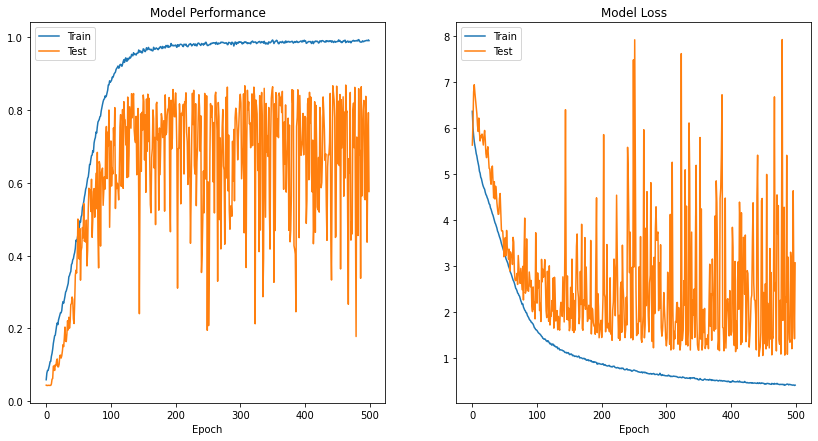


Model evaluation


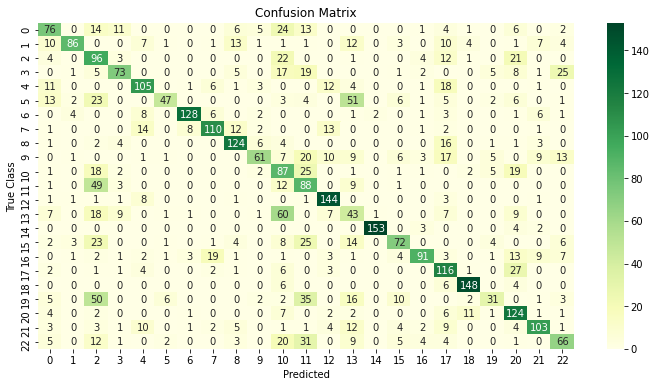

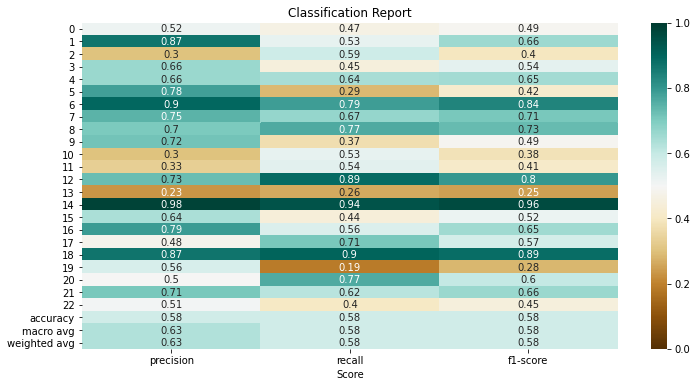

ACCURACY:  57.9 %
Elapsed time: 3983 seg (7.5 epochs/minute):


In [4]:
gpu = True
workers = 10
epochs = 500
batch_size = 128
start = time.time()

k = cnn_keras(X=X_train, y=y_train, gpu=gpu, workers=workers)

opt = Adam(lr=1e-4, decay=1e-4/epochs)
reg = l2(0.0005)

model = StridedNetSix.build(width=width, height=height, depth=depth, 
                            classes=len(classes), reg=reg)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

print('\nTraining started: using ClassSix')
history = model.fit(k.X, k.y, epochs=epochs, batch_size=batch_size, verbose=1, 
                    validation_split=0.2, workers=k.workers, use_multiprocessing=k.multicore)
k.printHistory(history.history, metric='accuracy')

print('\nModel evaluation')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
k.printPerformanceC(X_test, y_test, model=model)

et = time.time()-start
print('Elapsed time: %d seg (%.1f epochs/minute):' %(et, (60*epochs/et)))  

## Comparação GPU x CPU

In [4]:
def extractInfo(name):
    category = name.split(' ')
    return category[0]

def createData(path, size, to_cat=False):
    X, y = [], []
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = extractInfo(category)
        img_array = cv2.imread(os.path.join(path, p), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(size, size))
        X.append(new_img_array)
        y.append(category)
    X = np.array(X)
    X = X.reshape((X.shape[0], size, size, 1))
    X = X.astype('float32') / 255
    y = np.array(y)
    if to_cat:
        le = LabelEncoder()
        yy = le.fit_transform(y)
        y = to_categorical(yy)
    decoder = lambda cat_code: le.inverse_transform(cat_code)
    return X, y, decoder

path = '/home/lazarop/Downloads/wingsEval'
X, y, decoder = createData(path, 80, to_cat=True)

# teste se o decoder está funcionando corretamente
decoder([5, 6, 7])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [8]:
input_dim = (80, 80, 1)
output_dim = 23

kernel0 = 7
kerneli = 3
conv = 32
drop = 0.5

bench = []

epochs = 2
gpu = False
batch_size = 256

workers = 10
start = time.time()
k = cnn_keras(X=X_train, y=y_train, gpu=gpu, workers=workers)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_dim))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(output_dim, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(k.X, k.y, epochs=100, batch_size=batch_size, verbose=0, validation_split=0.2, 
      shuffle=True, workers=k.workers, use_multiprocessing=k.multicore)
print('\nModel evaluation')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
bench.append([gpu, workers, batch_size, epochs, time.time()-start, test_acc])


Versions:
Keras : 2.2.4-tf
Tensorflow : 2.1.0

GPU disabled!
Using 10 CPU workers
Multiprocessing status: True

Neural network setup:
X data shape:             (1292, 80, 80, 1)
y data shape:             (1292, 23)

Model evaluation


In [9]:
gpu = True
workers = 1
for batch_size in [16, 32, 64, 128, 256]:
    start = time.time()
    try:
        del k
    except:
        pass
    k = cnn_keras(X=X_train, y=y_train, gpu=gpu, workers=workers)
    history = model.fit(k.X, k.y, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.2, 
          shuffle=True, workers=k.workers, use_multiprocessing=k.multicore)
    print('\nModel evaluation')
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    bench.append([gpu, workers, batch_size, epochs, time.time()-start, test_acc])


Versions:
Keras : 2.2.4-tf
Tensorflow : 2.1.0

GPU was not found. Using CPU instead!
Multiprocessing status: False

Neural network setup:
X data shape:             (1292, 80, 80, 1)
y data shape:             (1292, 23)

Model evaluation

Versions:
Keras : 2.2.4-tf
Tensorflow : 2.1.0

GPU was not found. Using CPU instead!
Multiprocessing status: False

Neural network setup:
X data shape:             (1292, 80, 80, 1)
y data shape:             (1292, 23)

Model evaluation

Versions:
Keras : 2.2.4-tf
Tensorflow : 2.1.0

GPU was not found. Using CPU instead!
Multiprocessing status: False

Neural network setup:
X data shape:             (1292, 80, 80, 1)
y data shape:             (1292, 23)

Model evaluation

Versions:
Keras : 2.2.4-tf
Tensorflow : 2.1.0

GPU was not found. Using CPU instead!
Multiprocessing status: False

Neural network setup:
X data shape:             (1292, 80, 80, 1)
y data shape:             (1292, 23)

Model evaluation

Versions:
Keras : 2.2.4-tf
Tensorflow : 2.1.0



In [10]:
df_bench = pd.DataFrame(bench)
df_bench.columns = ['GPU', 'Workers', 'Batch Size', 'Epochs', 'Elapsed Time', 'Accuracy']
df_bench

,GPU,Workers,Batch Size,Epochs,Elapsed Time,Accuracy
0,False,10,256,2,91.024204,0.216049
1,True,1,16,2,2.376423,0.268519
2,True,1,32,2,2.009781,0.253086
3,True,1,64,2,2.077269,0.206790
4,True,1,128,2,2.029579,0.237654
5,True,1,256,2,2.011888,0.219136
